# 语音信号特征提取
语音波形中含有丰富的信息，蕴含语义，情绪，以及说话人个性信息等，特征提取就是去除语音的多余信息，挖掘出具有代表性、区分性、稳定性的参数的过程。由于语音的短时平稳性，往往通过短时分析，得到以帧为单位的特征矢量，常用的特征有基频特征，短时倒谱特征，如梅尔频率倒谱系数(Mel-Frequency Cepstral Coefficients，MFCC)等。
## 端点检测
端点检测就是从连续语音信号中检测出实际语音片段的起始点和终止点，从而提取出有效的语音片段，排除噪声等非语音信号的干扰，为后续语音处理系统提供可靠干净的语音信号。一般而言，一段语音波形中，分为无声区与有声区，噪声属于无声区，有声区包括浊音部分以及清音部分，这两部分才是有用的语音，端点检测就是将这两部分区分出来，注意，清音部分属于声音中辅音，具有能量小，过零率高，一般在浊音部分的前面。这里主要介绍结合短时能量与过零率进行端点检测的算法--双门限语音端点检测。
<center> ![vad](./vad.png)</center>
1. 取一个较高能量的短时能量作为阈值MH,利用该阈值，可以先分出浊音部分，MH一般可以取所有帧的平均短时能量的一半
2. 取一个较低的能量阈值ML,利用该阈值可以从A1，A2向两端进行搜索，将较低能量段的语音部分也加入到语音段，进一步扩大语音段范围，一般该能量阈值是通过计算开始的一段语音的能量均值，并将静音部分的能量均值和MH的平均数的一半作为ML.
3. 利用短时过零率，短时过量率的阈值为Zs，由于语音两端部分是辅音，也是语音的一部分，但是辅音的能量与静音部分的能量一样很低，但是过零率比静音部分高出很多，为了区分两者，将利用短时能量区分过的语音段继续向两端搜索，短时过零率大于3倍Zs的部分，则认为是语音清音部分，将该部分加入语音段，就是得到的语音段。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import wave
%matplotlib inline

较高能量阈值，计算后的浊音A:[19, 78, 129, 189, 232, 297, 336, 399, 440, 505]
较低能量阈值，增加一段语音B:[16, 84, 123, 196, 230, 298, 334, 401, 438, 506]
过零率阈值，最终语音分段C:[16, 84, 123, 196, 230, 298, 334, 401, 438, 506]


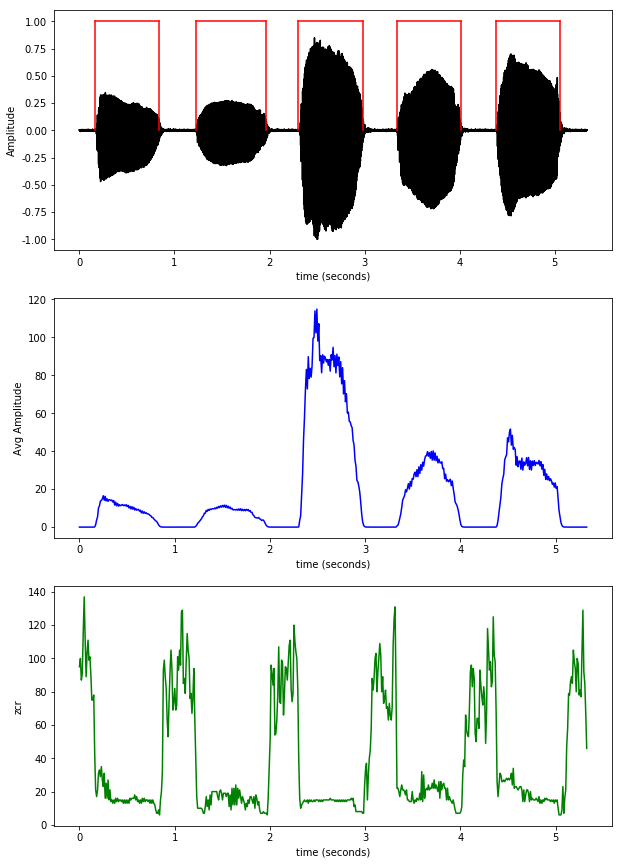

In [2]:
wavfile = os.path.join('.','aeiou.wav')
audio = wave.open(wavfile,'rb')
nchannels = audio.getnchannels()
sampwidth= audio.getsampwidth()
framerate = audio.getframerate()
nframes = audio.getnframes()
# nchannels, sampwidth, framerate, nframes = params[:4]
strData = audio.readframes(nframes)
waveData = np.frombuffer(strData, dtype=np.short)
waveData = waveData * 1.0/max(abs(waveData))

waveData = np.reshape(waveData, [nframes,nchannels]).T
audio.close()

def enframe(signal, nw, inc, winfunc):
    '''
    signal:波形
    nw: 帧长
    inc:帧移
    '''
    signal_length=len(signal)
    if signal_length<=nw:
        nf=1
    else: #否则，计算帧的总长度
        nf=int(np.ceil((1.0*signal_length-nw+inc)/inc))
    pad_length=int((nf-1)*inc+nw) #所有帧加起来总的铺平后的长度
    zeros=np.zeros((pad_length-signal_length,)) #不够的长度使用0填补，类似于FFT中的扩充数组操作
    pad_signal=np.concatenate((signal,zeros)) #填补后的信号记为pad_signal
    indices=np.tile(np.arange(0,nw),(nf,1))+np.tile(np.arange(0,nf*inc,inc),(nw,1)).T  #相当于对所有帧的时间点进行抽取，得到nf*nw长度的矩阵
    indices=np.array(indices,dtype=np.int32) #将indices转化为矩阵
    frames=pad_signal[indices] #得到帧信号
    win=np.tile(winfunc(nw),(nf,1))  #window窗函数，这里默认取1
    return frames*win   #返回帧矩阵
# 帧长25ms，帧移10ms
framesize = int(0.025*framerate)
frameshift = int(0.01*framerate)
framesData = enframe(waveData[0], framesize, frameshift, np.ones)
# 计算短时平均幅度
En = np.sum(np.square(framesData), axis=1)
nframes = framesData.shape[0]
zcr = np.zeros((nframes,1))
for i in range(nframes):
    curframe = framesData[i]
    curframe = curframe - np.mean(curframe)
    zcr[i] = sum(curframe[:-1]*curframe[1:] <=0) 
    
def endPointDetect(energy, zeroCrossingRate) :
    sum = 0
    energyAverage = 0
    for en in energy :
        sum = sum + en
    energyAverage = sum / len(energy)

    sum = 0
    for en in energy[:5] :
        sum = sum + en
    ML = sum / 5                        
    MH = energyAverage / 4              #较高的能量阈值
    ML = (ML + MH) / 4   #较低的能量阈值
    sum = 0
    for zcr in zeroCrossingRate[:5] :
        sum = float(sum) + zcr             
    Zs = sum / 5                     #过零率阈值

    A = []
    B = []
    C = []

    # 首先利用较大能量阈值 MH 进行初步检测
    flag = 0
    for i in range(len(energy)):
        if len(A) == 0 and flag == 0 and energy[i] > MH :
            A.append(i)
            flag = 1
        elif flag == 0 and energy[i] > MH and i - 21 > A[-1]:
            A.append(i)
            flag = 1
        elif flag == 0 and energy[i] > MH and i - 21 <= A[-1]:
            A = A[:-1]
            flag = 1

        if flag == 1 and energy[i] < MH :
            A.append(i)
            flag = 0
    print("较高能量阈值，计算后的浊音A:" + str(A))
    # 利用较小能量阈值 ML 进行第二步能量检测
    for j in range(len(A)) :
        i = A[j]
        if j % 2 == 1 :
            while i < len(energy) and energy[i] > ML :
                i = i + 1
            B.append(i)
        else :
            while i > 0 and energy[i] > ML :
                i = i - 1
            B.append(i)
    print("较低能量阈值，增加一段语音B:" + str(B))
    # 利用过零率进行最后一步检测
    for j in range(len(B)) :
        i = B[j]
        if j % 2 == 1 :
            while i < len(zeroCrossingRate) and zeroCrossingRate[i] >= 3 * Zs :
                i = i + 1
            C.append(i)
        else :
            while i > 0 and zeroCrossingRate[i] >= 3 * Zs :
                i = i - 1
            C.append(i)
    print("过零率阈值，最终语音分段C:" + str(C))
    return C

segs = endPointDetect(En,zcr)

time = np.arange(0, len(waveData[0])) * (1.0 / framerate)
time2 = np.arange(0, len(En))*(len(waveData[0])/len(En) / framerate)
time3 = [s*frameshift*1.0/framerate for s in segs]

plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
plt.plot(time,waveData[0], c='black')
for i in range(0,len(time3),2):
    plt.plot([time3[i],time3[i]],[0,1],c='r')
    plt.plot([time3[i+1],time3[i+1]],[0,1],c='r')
    plt.plot([time3[i], time3[i+1]], [1,1], c='r')
plt.xlabel("time (seconds)")
plt.ylabel("Amplitude")
plt.subplot(3,1,2)
plt.plot(time2,En,c='b')
plt.xlabel("time (seconds)")
plt.ylabel("Avg Amplitude")
plt.subplot(3,1,3)
plt.plot(time2,zcr,c='g')
plt.xlabel("time (seconds)")
plt.ylabel("zcr")
plt.show()

## 基音周期估计
人在发音的时候，根据声带是否振动可以将语音信号分为清音与浊音两种，浊音也称有声部分，携带着语音中大部分的能量，浊音在时域上呈现出明显的周期性，而清音类似于白噪声，不存在周期性。发浊音时，气流通过声门使声带产生张弛震荡式振动，产生准周期的激励脉冲串，这种声带振动的频率称为基音频率，相应的周期称为基音周期。

通常，基音频率与个人声带的长短、韧性以及发音习惯等有关系，在很大程度上反映了个人的特征，一般来说，男性说话时候基音频率较低，而女性与小孩的基音频率相对较高。基音周期的估计称为基音检测，基音检测的最终目的是为了找出与声带振动频率完全一致的或者尽可能吻合的轨迹曲线。基音周期作为语音信号中描述激励源的重要参数之一，在语音合成、语音识别和说话人识别等领域有着广泛而重要的应用。

关于基音周期的估计有很多方法，比如基于短时自相关函数，基于倒谱的基音周期估计等，下面主要介绍使用短时自相关函数进行基音检测，做基音检测首先需要要区分出浊音。

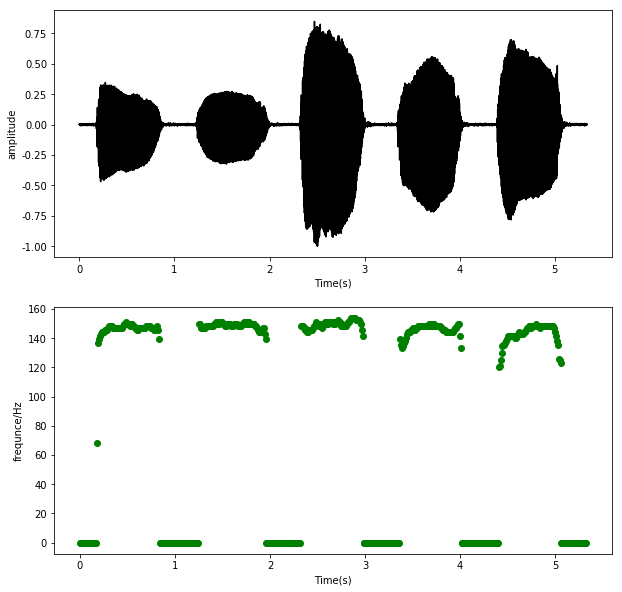

In [3]:
def calPitch(frame, fs):
    flen = len(frame)
    acf = np.zeros(flen)
    for i in range(flen):
        acf[i] = np.sum(frame[i:flen]*frame[0:flen-i])

    # 提取基频，假设基频位于50-600Hz
    lmax = np.round((fs*1.0/50))
    lmin = np.round((fs*1.0/500))
    
    
    loc = np.argmax(acf[int(lmin):int(lmax)])

    pos = lmin + loc - 1
    pitch = fs*1.0/pos
    return  pitch

pitchtrack = np.zeros(nframes)
for i in range(0,len(segs),2):
    #考虑到浊音部分的前面存在清音，可能会预测的不准，所以每段的开始加两帧，去除一些野点
    for s in range(segs[i]+2, segs[i+1]):
        cur_frame = framesData[s]
        pitch = calPitch(cur_frame, framerate)
        pitchtrack[s] = pitch
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(time,waveData[0], c='black')
plt.xlabel('Time(s)')
plt.ylabel('amplitude')
plt.subplot(2,1,2)
plt.scatter(time2,pitchtrack, c='g')
plt.xlabel('Time(s)')
plt.ylabel('frequnce/Hz')
plt.show()

基音估计往往会存在检测错误，常出现检测出半频以及倍频的问题，此外，还可以使用AMDF函数进行检测，以及AMDF的相关改进方案，都可以进行尝试，无论采用哪一种基音检测算法都可能产生检测错误，使得基音周期轨迹中存在一些偏离正常轨迹，这些偏离点称为基音轨迹的"野点"，为了去除这些野点，可以采用各种平滑算法，其中最常见的是中值平滑算法，和线性平滑算法，这里不再赘述。

## 梅尔频率倒谱系数
梅尔频率倒谱系数(Mel Frequency Cepstral Coeffients, MFCC)是一种短时倒谱参数特征，该参数的提取过程考虑到人耳听觉系统的非线性特性，也就是说，人耳感受的声音频率与实际上的物理频率是有差别的，呈现非线性关系，人耳的听觉特性更倾向于Mel频率刻度。梅尔频率与实际物理频率的关系可以使用下式来表示：

$$ Mel(f) = 2595log(1 + f/700)$$
人耳的听觉系统为一非线性系统，在其感知的频带存在掩蔽现象，即在某一带宽范围内，一个音的响度正好等同于具有此带宽的噪声的响度，则处于刚好听不到的临界状态，此时的带宽称为临界带宽，我们可以使用临界带宽，将人耳感知频率的范围划分为若干个三角形滤波器组，也就是Mel滤波器组，对于每一个三角滤波器，与在其带宽的语音信号的幅度谱加权求和，即可得到此滤波器的输出。Mel滤波器组的各个三角滤波器的带宽不是相同的，而是随频率的增大而增大。下面具体实现mfcc特征的提取过程：

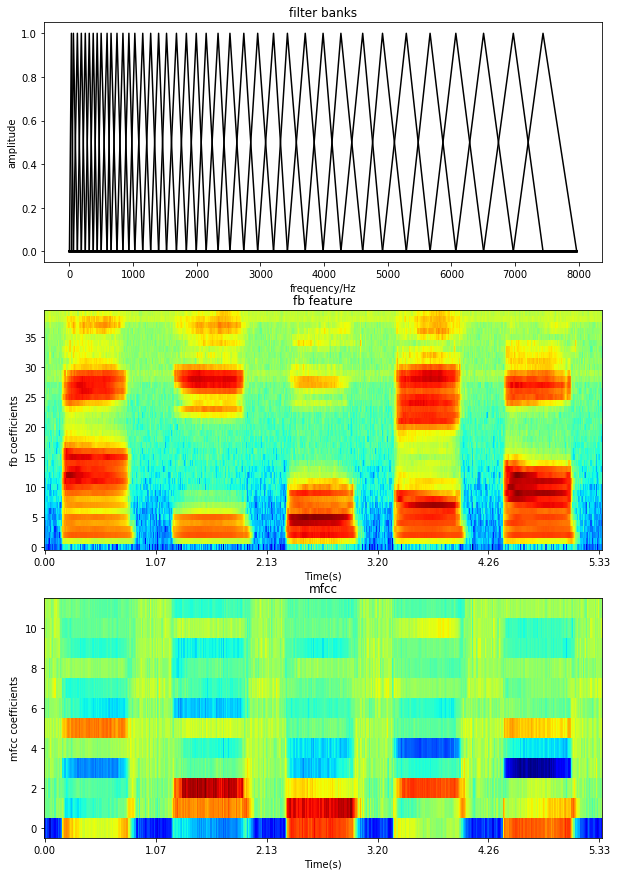

In [4]:
from scipy.fftpack import dct
# 预加重系数
pre_emphasis = 0.97
# 预加重
emphasized_signal = np.append(waveData[0][0], waveData[0][1:]-pre_emphasis*waveData[0][:-1])
framesize = int(0.025*framerate)
frameshift = int(0.01*framerate)
framesdata = enframe(emphasized_signal, framesize, frameshift, np.hamming)
# fft的点数
nfft = 512
# 幅度谱
mag_frames = np.absolute(np.fft.rfft(framesdata, nfft))
# 功率谱
pow_frames = (1.0/nfft)*((mag_frames)**2)
# 三角滤波器组的个数
nfilter = 40
low_freq_mel = 0
high_freq_mel = (2595*np.log10(1 + (framerate/2)/700))
# 在梅尔刻度上等距划分
mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilter + 2)
# 转换到实际物理频率上
hz_points = (700*(10**(mel_points/2595) -1))
bins = np.floor((nfft+1)*hz_points/framerate)
# 每个滤波器的频率范围都是0-fs/2
fbank = np.zeros((nfilter,int(np.floor(nfft/2+1))))
for m in range(1, nfilter + 1):
    f_m_minus = int(bins[m-1])
    f_m = int(bins[m])
    f_m_plus = int(bins[m+1])
    
    for k in range(f_m_minus, f_m):
        fbank[m-1, k] = (k - bins[m-1])/(bins[m] - bins[m-1])
    for k in range(f_m, f_m_plus):
        fbank[m-1, k] = (bins[m+1] - k)/(bins[m+1] - bins[m])
        
plt.figure(figsize=(10,15))
plt.subplot(3,1,1)
for i in range(0, nfilter):
    tri_filter = fbank[i]
    freq = np.arange(0,len(tri_filter))*framerate/(2*len(tri_filter))
    plt.plot(freq,tri_filter, c='black')
plt.xlabel('frequency/Hz')
plt.ylabel('amplitude')
plt.title('filter banks')


filter_banks = np.dot(pow_frames, fbank.T)
# 数值稳定
filter_banks = np.where(filter_banks==0, np.finfo(float).eps, filter_banks)
# 转化到dB单位上，，此处得到也是常用的特征filterbank特征
filter_banks = 20*np.log10(filter_banks)
# 使用DCT进行去相关,只保留前1-13维，即最后的mfcc特征
num_ceps = 12
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:,1:(num_ceps + 1)]
'''
# 频谱提升
cep_lifter = 22
lift = 1 + (cep_lifter/2)*np.sin(np.pi*mfcc.shape[1]/cep_lifter)
mfcc *=lift
'''
# 画filterbank的热力图
plt.subplot(3,1,2)
plt.imshow(filter_banks.T,cmap=plt.cm.jet,aspect='auto')
plt.xlabel('Time(s)')
plt.ylabel('fb coefficients')
nframes = (filter_banks.T).shape[1]
plt.xticks(np.arange(0, nframes,
                    int(nframes/5)),
                    ['{:.2f}'.format(i*nframes/5*frameshift/framerate) for i in range(6)])
ax = plt.gca()
ax.invert_yaxis()
plt.title('fb feature')
# 画MFCC的热力图
plt.subplot(3,1,3)
plt.imshow(mfcc.T,cmap=plt.cm.jet,aspect='auto')
plt.xlabel('Time(s)')
plt.ylabel('mfcc coefficients')
plt.xticks(np.arange(0, nframes,
                    int(nframes/5)),
                    ['{:.2f}'.format(i*nframes/5*frameshift/framerate) for i in range(6)])
ax = plt.gca()
ax.invert_yaxis()
plt.title('mfcc')
plt.show()

在提出MFCC过程中，也得到另一个常用的声学特征filter bank特征，mfcc特征只是在filter bank特征进行去相关操作得到，同时也损失一些有用的信息，特别是在深度学习模型，本身可以特征间的相关性，因此不用去相关操作，直接使用filter bank特征，mfcc一般使用GMM做声学模型时使用的，因为GMM假设特征不相关，其协方差矩阵可以是对角阵，所以mfcc更符合此要求。除此之外，大量实验表明，在语音特征中加入表征语音动态特性的差分参数，可以提高系统的性能，因此，也会使用一阶差分参数以及二阶差分参数进行拼接而成最终的特征向量，具体的实现很简单，这里不再赘述。
## 语谱图
近年来，卷积神经网络在图像识别领域中取得重大的进展,但是其主要是针对图像领域，语音波形经过短时频域变化，可以变成等价的语谱图，而且语谱图蕴含更多有用的信息，使用卷积神经网络可以更好提取有用的特征。下面具体介绍语谱图的生成：

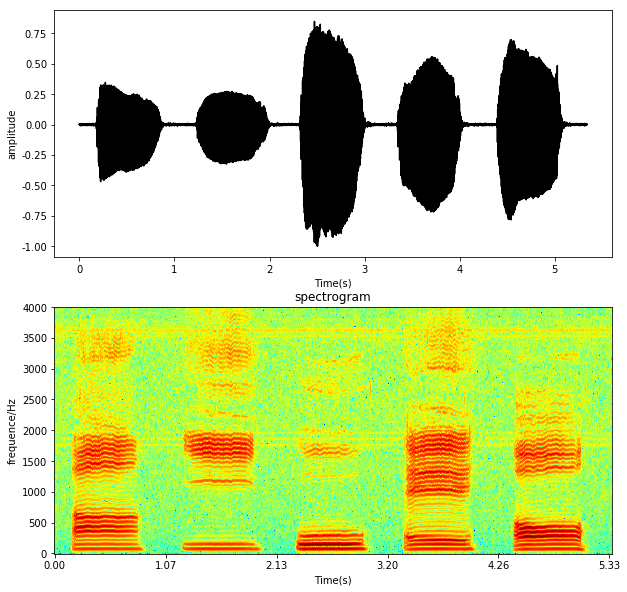

In [7]:
# 生成语谱图不需要进行预加重，但需要使用汉明窗，防止频谱泄露
Dataframes = enframe(waveData[0], framesize, frameshift, np.hamming)
# fft变换点数
nfft = 512
eps = 1e-10
spectrogram = np.absolute(np.fft.rfft(framesdata, nfft))
spectrogram = np.log10(np.abs(spectrogram)+ eps)

plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(time,waveData[0],c='black')
plt.xlabel('Time(s)')
plt.ylabel('amplitude')
plt.subplot(2,1,2)
plt.imshow(spectrogram.T,cmap=plt.cm.jet,aspect='auto')
plt.xlabel('Time(s)')
plt.ylabel('frequence/Hz')
nframes = spectrogram.shape[0]
dim = spectrogram.shape[1]
plt.xticks(np.arange(0, nframes,
                    int(nframes/5)),
                    ['{:.2f}'.format(i*nframes/5*frameshift/framerate) for i in range(6)])
plt.yticks(np.arange(0,dim,int(dim/8)),
                    ['{}'.format(int(i*framerate/(2*16))) for i in range(9)])
ax = plt.gca()
ax.invert_yaxis()
plt.title('spectrogram')
plt.show()